# Demo 08 - Predictive Models: Regression

In this notebook we look at the basics of how to do a linear regression using various Python modules. We don't do gradient descent directly because it's easier to just use modules!

In [1]:
# clone the course repository, change to right directory, and import libraries.
%cd /content
!git clone https://github.com/nmattei/cmps3160.git
%cd /content/cmps3160/_demos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
plt.style.use('fivethirtyeight')
# Make the fonts a little bigger in our graphs.
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['pdf.fonttype'] = 42

/content
Cloning into 'cmps3160'...
remote: Enumerating objects: 1641, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 1641 (delta 316), reused 441 (delta 260), pack-reused 1110
Receiving objects: 100% (1641/1641), 42.84 MiB | 25.08 MiB/s, done.
Resolving deltas: 100% (917/917), done.
/content/cmps3160/_demos


## Loading and Understanding the Data

For this work we will be using data from: Generalized body composition prediction equation for men using simple measurement techniques", K.W. Penrose, A.G. Nelson, A.G. Fisher, FACSM, Human Performance research Center, Brigham Young University, Provo, Utah 84602 as listed in Medicine and Science in Sports and Exercise, vol. 17, no. 2, April 1985, p. 189.

[Data availabe here.](https://www2.stat.duke.edu/courses/Fall09/sta290/datasets/bodyfat.txt)


In [2]:
# Load the Penrose Data and have a look.
df_penrose = pd.read_csv("./data/bodyfat.csv")
df_penrose.head()

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [3]:
# This is a bit much so let's only use a smaller part of the data for the moment.
features = ['Age', 'Neck', 'Forearm', 'Wrist']
df_penrose[features + ['bodyfat']].head()

,Age,Neck,Forearm,Wrist,bodyfat
0,23,36.2,27.4,17.1,12.3
1,22,38.5,28.9,18.2,6.1
2,22,34.0,25.2,16.6,25.3
3,26,37.4,29.4,18.2,10.4
4,24,34.4,27.7,17.7,28.7


In [4]:
# How many observations do we have?
len(df_penrose)

252

Let's do some really basic scatter plotting...

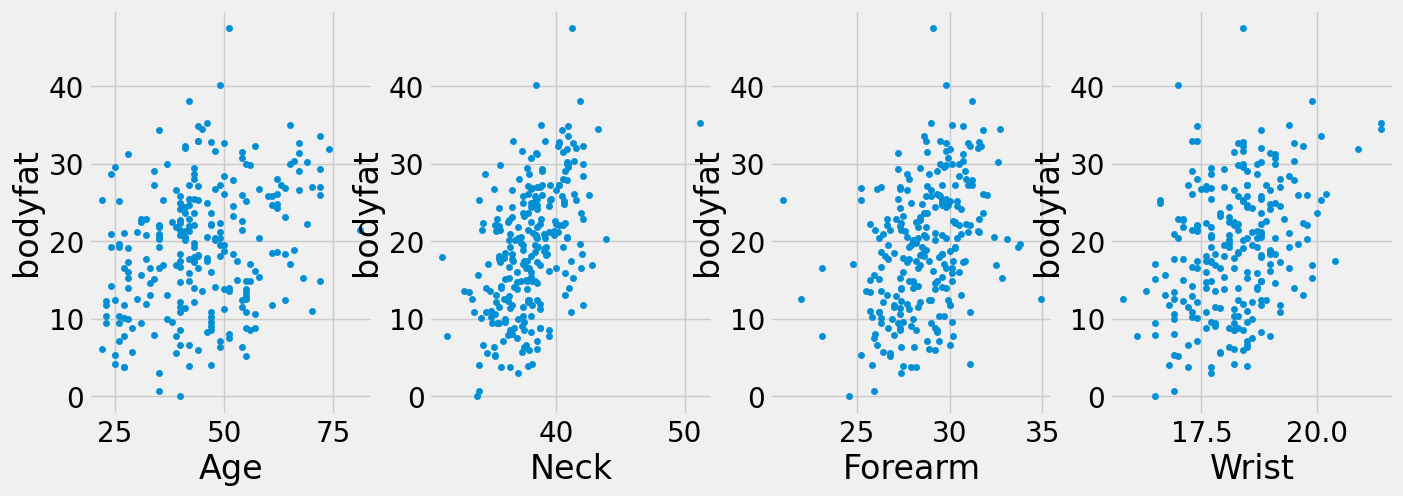

In [5]:
# First we iterate over the features and see what we have.
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,f in enumerate(features):
    df_penrose.plot.scatter(x=f, y='bodyfat', ax=ax[i])

## Many Ways to Find a Linear Regression

Let's say we want to look at some linear regressions of single variables to see what is going on!  So let's plot some regression lines.  Note that there are at least a few different ways -- [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), [sklearn.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial), [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), and [statsmodels](https://www.statsmodels.org/stable/index.html).

Here's a good article about it [Data science with Python: 8 ways to do linear regression and measure their speed](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/).

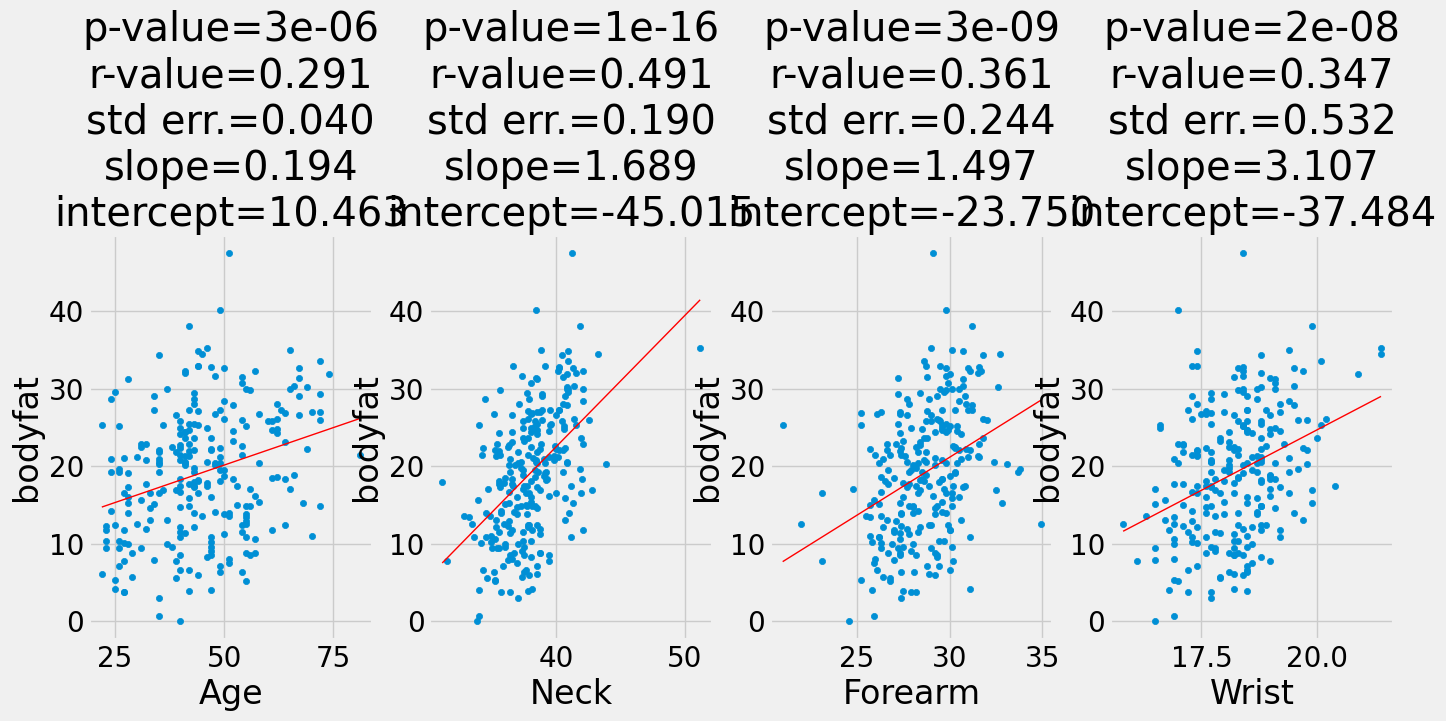

In [6]:
import math
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value is whether or not the slope is 0, not if the correlation is significant.
def regress_with_stats(df_penrose, features):
  fig, ax = plt.subplots(1, 4, figsize=(15,5), sharex=False)

  for i,f in enumerate(features):
      slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[f],
                                                                     df_penrose['bodyfat'])
      # Pack these into a nice title
      diag_str = "p-value=%.1g\nr-value=%.3f\nstd err.=%.3f\nslope=%.3f\nintercept=%.3f" % (p_value, r_value, std_err, slope, intercept)
      df_penrose.plot.scatter(x=f, y='bodyfat', title=diag_str, ax=ax[i])
      y_pred = df_penrose[f] * slope + intercept
      # Make points and line
      pts = np.linspace(df_penrose[f].min(), df_penrose[f].max(), 500)
      line = slope * pts + intercept
      ax[i].plot(pts, line, lw=1, color='red')

      # for the curious, here is how std err of slope is computed:
      # stderr = math.sqrt(((y_pred-df_penrose['bodyfat'])**2).sum()/(len(y_pred)-2)  /  ((df_penrose['bodyfat']-df_penrose['bodyfat'].mean())**2).sum())
      # see: https://en.wikipedia.org/wiki/Ordinary_least_squares#Finite_sample_properties


regress_with_stats(df_penrose, features)

### Which feature seems most important/predictive?

<br><br><br><br><br>

### What happens if we scale all the values?

We compute the z-score of each column using the [`scipy.stats.zscore`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) function

In [7]:
from scipy.stats import zscore
df_penrose_scaled = df_penrose.apply(zscore)
# compare before and after
print('unscaled')
display(df_penrose.head(5))
print('scaled')
display(df_penrose_scaled.head(5))

unscaled


,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


scaled


,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,0.801647,-0.820246,-1.740073,-0.841246,-0.656205,-0.738665,-0.918048,-0.683533,-0.755929,-0.077479,-0.536131,-0.710826,-0.090676,-0.626718,-1.212541
1,1.565061,-1.562573,-1.819583,-0.193462,0.574790,0.209365,-0.858621,-0.887963,-0.168502,-0.134736,-0.536131,0.175947,-0.588143,0.117079,-0.031943
2,-0.746240,0.736245,-1.819583,-0.849769,-1.066536,-1.645475,-0.597144,-0.432643,-0.098570,0.037035,0.128592,0.530656,-1.151940,-1.717621,-1.749177
3,1.028039,-1.047733,-1.501543,0.198617,0.574790,-0.244041,0.115976,-0.572026,0.181157,0.132464,-0.536131,-0.178762,0.041982,0.365012,-0.031943
4,-1.135844,1.143327,-1.660563,0.181570,0.301235,-1.480601,-0.418864,0.691719,0.279061,0.724121,1.499585,0.530656,-0.024347,-0.477959,-0.568578


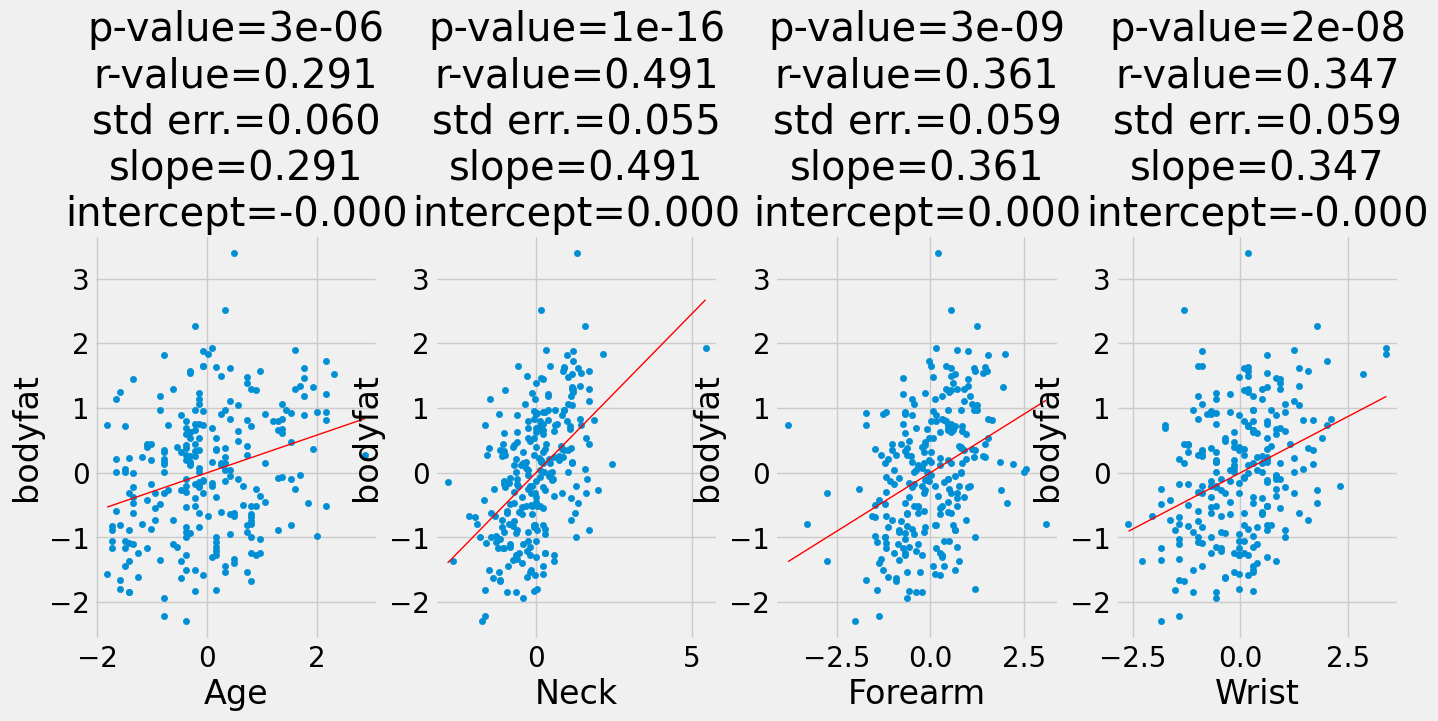

In [8]:
# now regress with scaled values.
regress_with_stats(df_penrose_scaled, features)

**What if we want to fit a multinomial regression? I.e., use all the features as input/independent variables**

In [9]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[features],
                                                               df_penrose['bodyfat'])









## oops; linregress assumes regression on one variable only.


ValueError: ignored

## Scikit-learn
Scikit-learn implements [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as well.

All regression/classification classes in scikit-learn assume two functions:

- `.fit(X, y)`: fit/train the model giving training data `X` (the feature matrix) and `y` (the true values)
- `.predict(X)`: given a feature matrix, return the predicted `y` values.

,truth,predicted
0,-0.820246,-0.762923
1,-1.562573,-0.408765
2,0.736245,-1.332367
3,-1.047733,-0.476792
4,1.143327,-1.173617


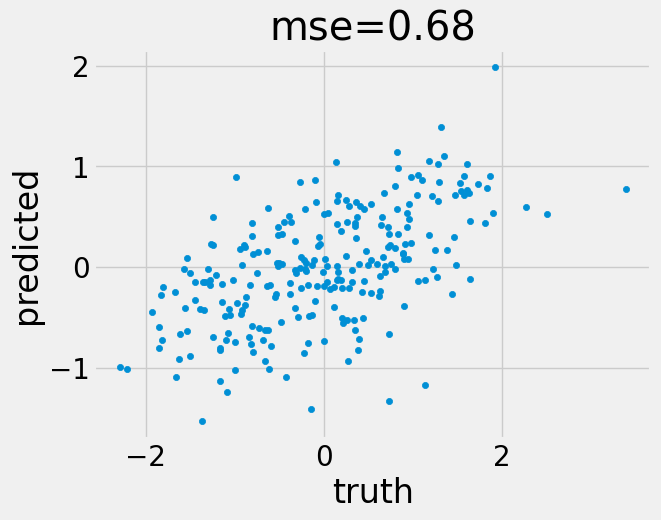

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# fit the model
lr.fit(df_penrose_scaled[features], df_penrose_scaled['bodyfat'])
# predict using the model
predictions = lr.predict(df_penrose_scaled[features])
# compare predictions to truth
truth_and_pred = pd.DataFrame(zip(df_penrose_scaled['bodyfat'], predictions), columns=['truth', 'predicted'])
mse = ((truth_and_pred.truth-truth_and_pred.predicted)**2).sum()/len(truth_and_pred)
truth_and_pred.plot.scatter(x='truth', y='predicted', title='mse=%.2f' % mse)
truth_and_pred.head()

### Mean-squared error
$$MSE = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$$

In [11]:
# what are the coefficients?
# print coefficients
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)
pd.DataFrame(zip(features, lr.coef_))

coef= [ 0.29460244  0.46715209  0.20201498 -0.18257659]
intercept= 8.325445303584595e-16


,0,1
0,Age,0.294602
1,Neck,0.467152
2,Forearm,0.202015
3,Wrist,-0.182577


### Why did the coefficients change so much?

## Let's actually make "predictions"

Up to now we've been fitting regression models on all the data and inspecting its goodness of fit. However, if we are using this as an actual predictive model, we'd want to assess how good the prediction is on **unseen** data.

In [12]:
df_train = df_penrose_scaled.sample(frac=0.5, random_state=42)
df_test = df_penrose_scaled.drop(df_train.index)
print('%d training and %d testing samples' % (len(df_train), len(df_test)))

126 training and 126 testing samples


<Axes: title={'center': 'mse=0.77'}, xlabel='truth', ylabel='predicted'>

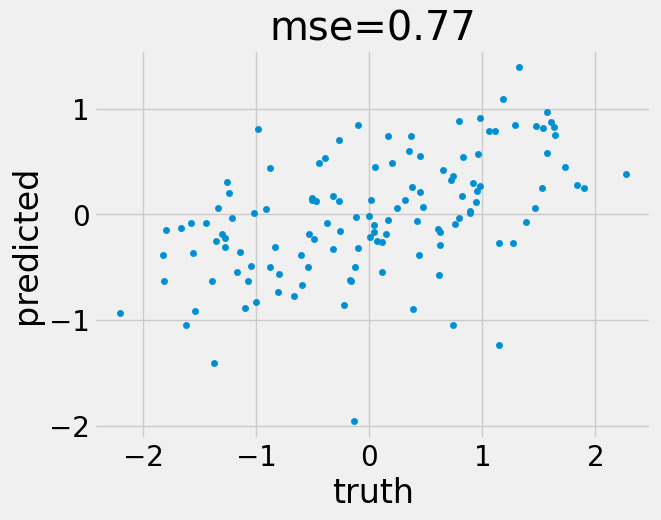

In [13]:
lr = LinearRegression()
lr.fit(df_train[features], df_train['bodyfat'])
predictions = lr.predict(df_test[features])
truth_and_pred = pd.DataFrame(zip(df_test['bodyfat'], predictions), columns=['truth', 'predicted'])
mse = ((truth_and_pred.truth-truth_and_pred.predicted)**2).sum()/len(truth_and_pred)
truth_and_pred.plot.scatter(x='truth', y='predicted', title='mse=%.2f' % mse)


### Why is MSE higher here?

We could also use the polyfit function

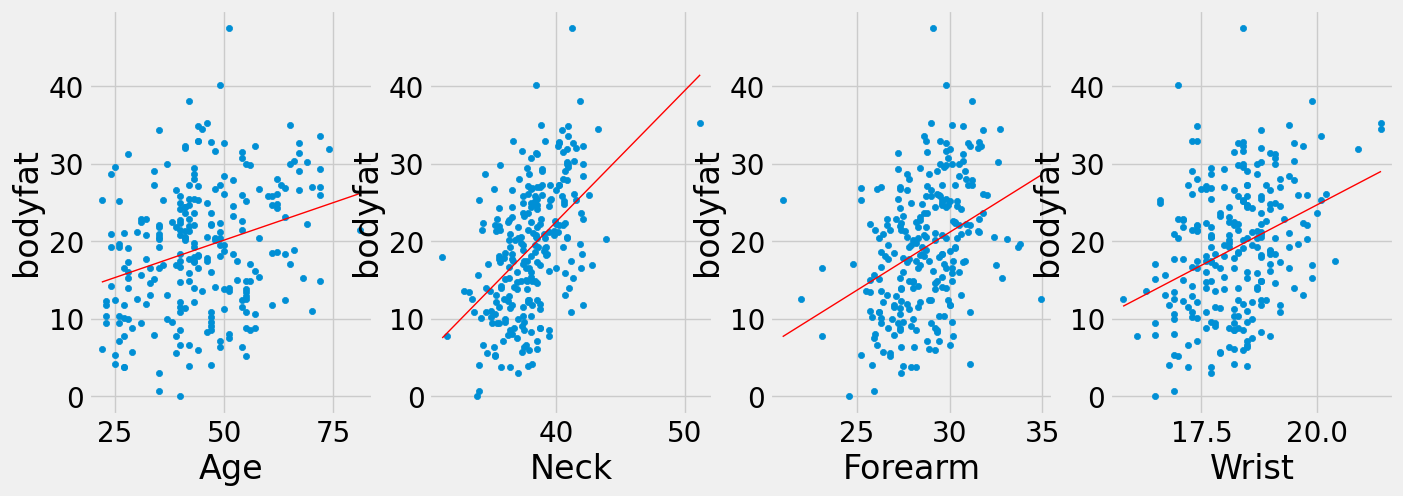

In [14]:
# Let's try to fit a linear model with PolyFit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(features):
    # Fit our curve
    x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 1)

    # Plot regular points
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot curve
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

## Non-Linear Models?

So far we have only looked at the linear case -- what happens if we try to fit a polynomial to this data?

Why would we want to fit some higher order polynomial on this data? Why is it a good idea or a bad idea?

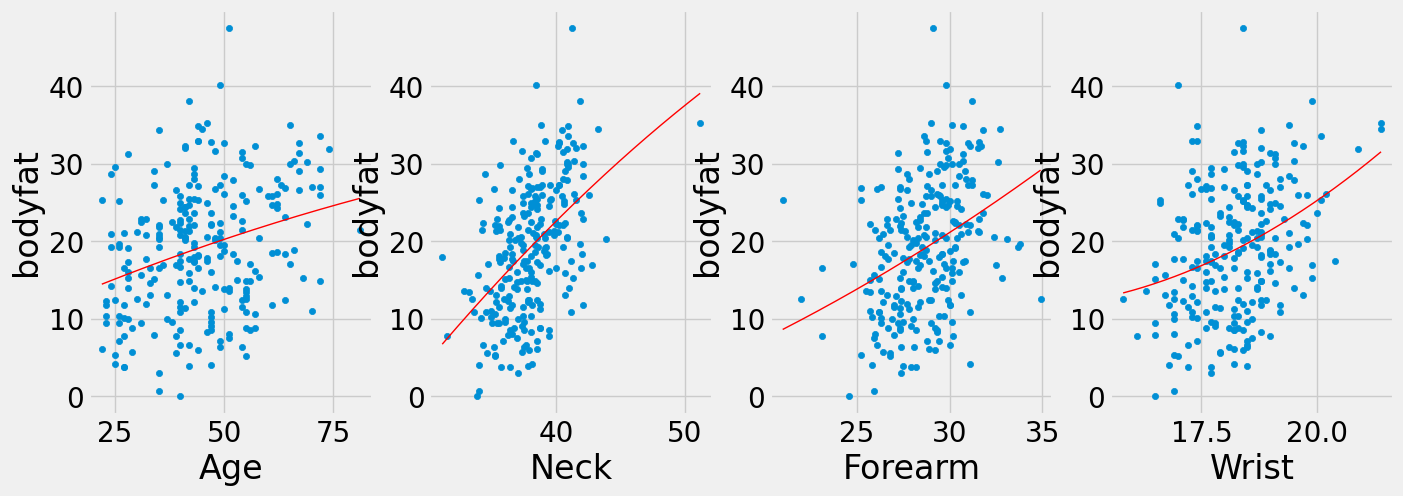

In [15]:
# Let's try fitting a degree 2 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(features):

    # Fit the polynomial.
    x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 2)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

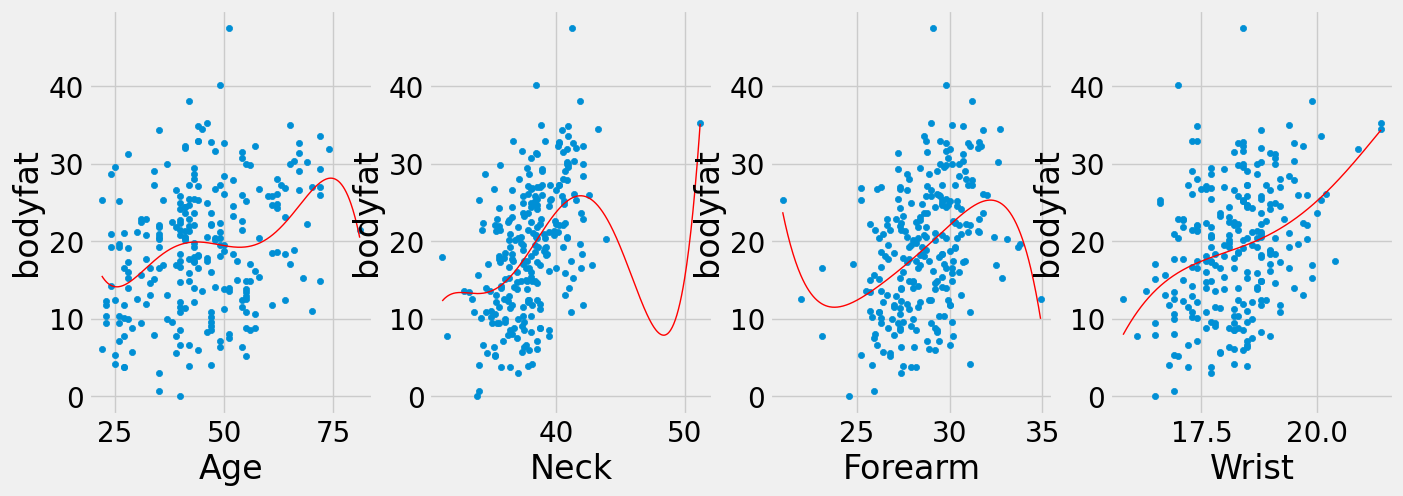

In [16]:
# Let's try fitting a degree 5 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(features):

    # Fit the polynomial.
    x5, x4, x3, x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 5)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x5 * pts**5 + x4 * pts**4 + x3 * pts**3 + x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

## Regressions and Plots with StatsModels and Seaborn

Statsmodels (you'll likely need to install it) gives a much more R-like interface to linear modeling.  You can read [more about it here](https://www.statsmodels.org/stable/index.html).

In [17]:
import statsmodels.api as sm
df_ind = df_penrose[['Neck', 'Wrist']]
df_target = df_penrose['bodyfat']

In [18]:
X = df_ind
y = df_target

# Note the difference in argument order
# Call: endog, then exog (dependent, indepenednt)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model
# Print out the statistics
model.summary()
#fig, ax = plt.subplots(figsize=(12,8))
#fig = sm.graphics.plot_partregress(endog="bodyfat", exog_i=['Abdomen', 'Neck'], exog_others='', data=df_penrose)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                bodyfat   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              823.5
Date:                Fri, 04 Aug 2023   Prob (F-statistic):                   9.64e-111
Time:                        21:22:14   Log-Likelihood:                         -868.15
No. Observations:                 252   AIC:                                      1740.
Df Residuals:                     250   BIC:                                      1747.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Neck           1.6874      0.295      5.714      0.000       1.106       2.269
Wrist         -2.4602      0.616     -3.995      0.000      -3.673      -1.247
==============================================================================
Omnibus:                        2.850   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.309
Skew:                           0.107   Prob(JB):                        0.315
Kurtosis:                       2.583   Cond. No.                         60.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use the [single regressor plot](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.graphics.api.plot_partregress.html#statsmodels.graphics.api.plot_partregress).

eval_env: 1


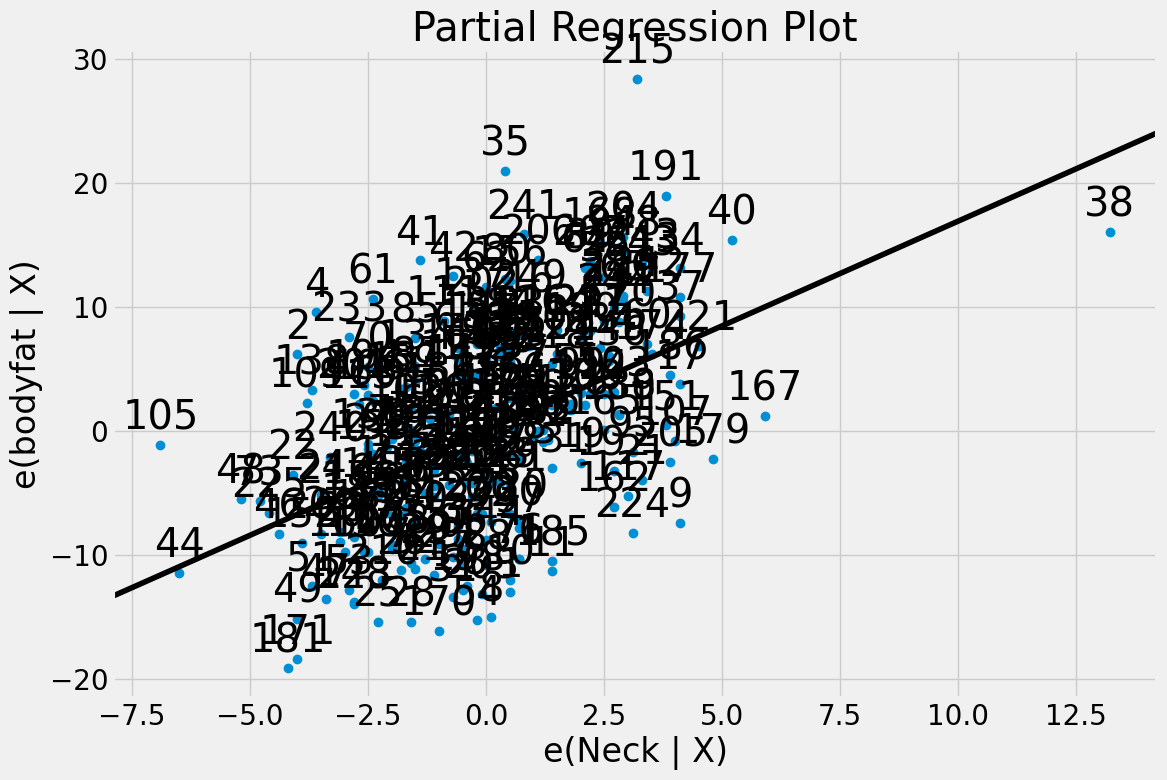

In [19]:
from statsmodels.graphics.regressionplots import plot_partregress
fig, ax = plt.subplots(figsize=(12,8))
plot_partregress(endog='bodyfat', exog_i='Neck', exog_others='', data=df_penrose, ax=ax)
plt.show()

If we have multiple elements in our regression then we need to use a different plot.

eval_env: 1
eval_env: 1


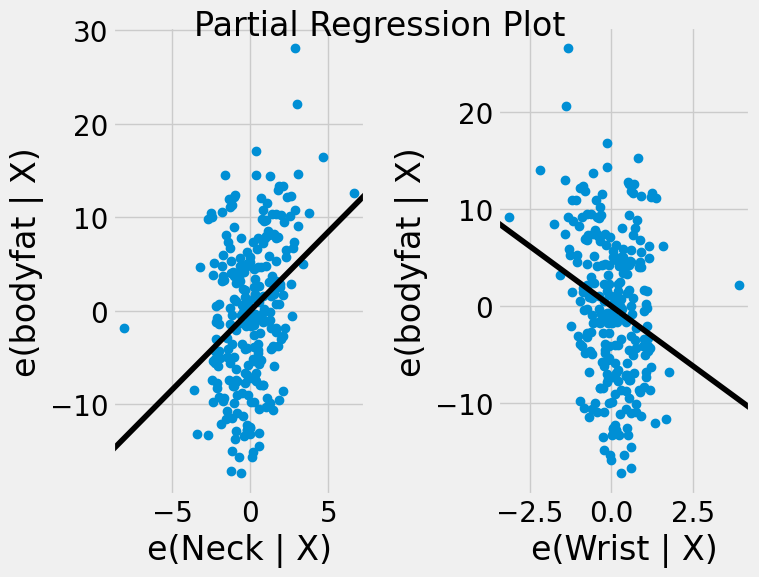

In [20]:
# Multiple regression plot
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(model, fig=fig)
plt.show()

Another way to work with regressions and their plots is using the [Seaborn Regression Package](https://seaborn.pydata.org/tutorial/regression.html)

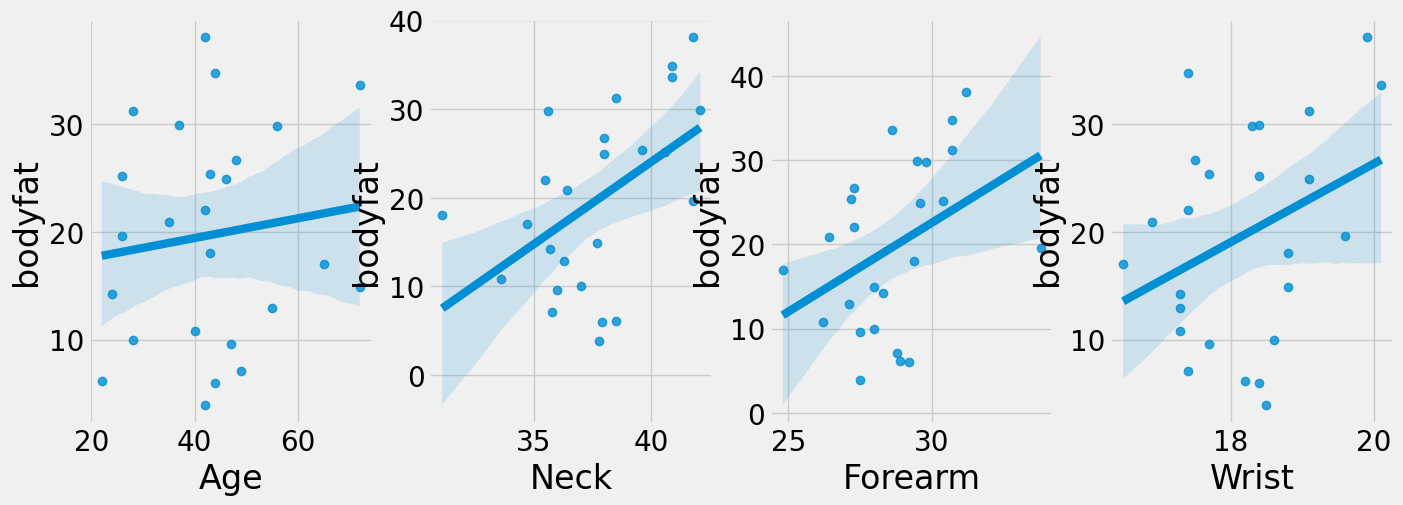

In [21]:
# Another way to do simple exploratory plots
import seaborn as sns
df_test = df_penrose.sample(frac=0.10, replace=False)
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(features):
    sns.regplot(x=o, y='bodyfat', data=df_test, ax=ax[i])
    #g.axes.set_xlim(df_test[o].min()*.95,df_test[o].max()*1.05)



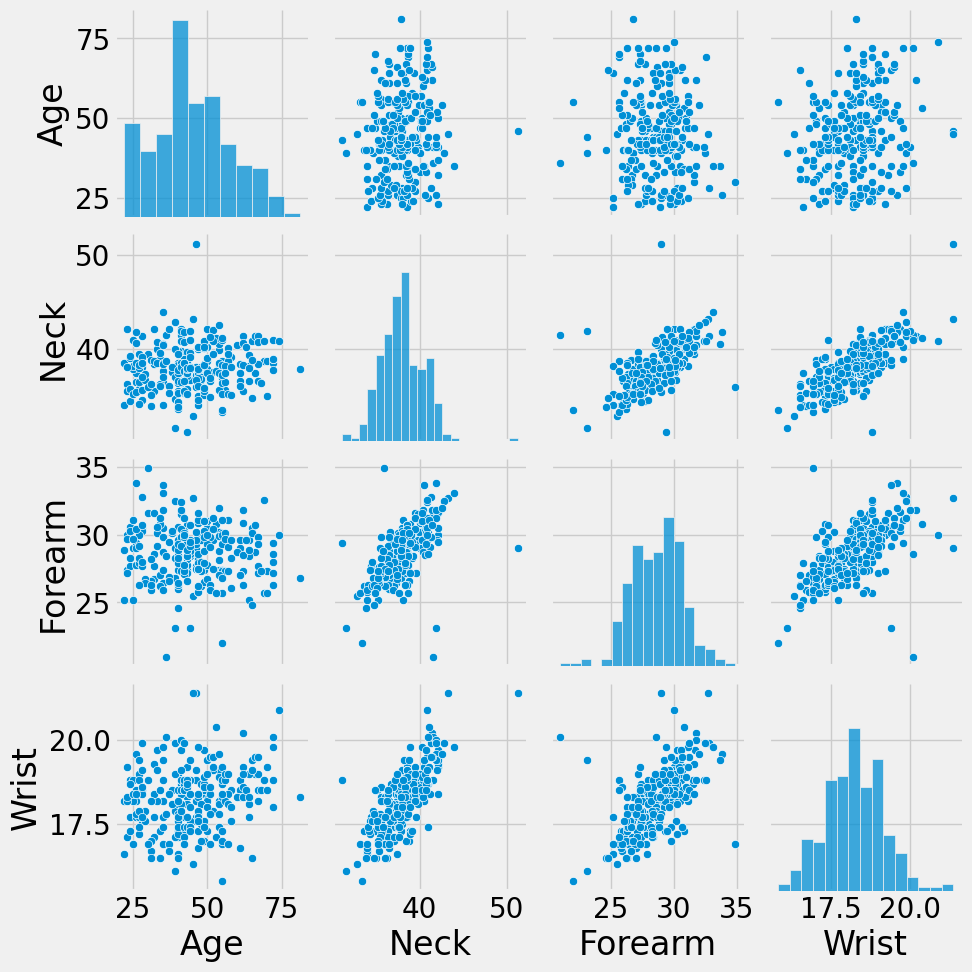

In [22]:
# As we saw before we can also use the sns pairplot.
sns.pairplot(df_penrose[features])

## Linear Regressions and the Bias v. Variance Tradeoff

Another nice simulator to play with is [this one](https://ndirienzo.shinyapps.io/linear_regression_sim/) which is from [Prof. Nicholas DiRienzo](https://ischool.arizona.edu/people/nicholas-dirienzo) from ASU's School of Information

## Logistic Regression

We can also use sklearn to do a quick logistic regression.  Remember that for logistic regression we are testing whether or not something is true, so we need to add a variable to our data.

Someone is obese if their body fat is >32% so we'll add a dummy for that!

In [23]:
df_penrose['obese'] = df_penrose.apply(lambda x: 1 if x['bodyfat'] > 32 else 0, axis=1)

In [24]:
df_penrose['obese'] = df_penrose.apply(lambda x: 1 if x['bodyfat'] > 32 else 0, axis=1)

In [25]:
# We're going to use sklearn to build us a classifier.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# setup our data for testing and training.

X_train, X_test, y_train, y_test = train_test_split(df_penrose[features],
                                                    df_penrose['obese'],
                                                    test_size=0.2)


In [26]:
X_train.head()

,Age,Neck,Forearm,Wrist
19,33,40.0,30.1,18.2
224,55,41.1,31.1,19.2
106,43,38.6,28.5,18.1
112,47,40.2,31.1,19.8
235,62,38.3,26.3,18.3


In [27]:
# Fit that model!
logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced')
model = logisticRegr.fit(X_train, y_train)

Accuracy Score is: 0.7843137254901961


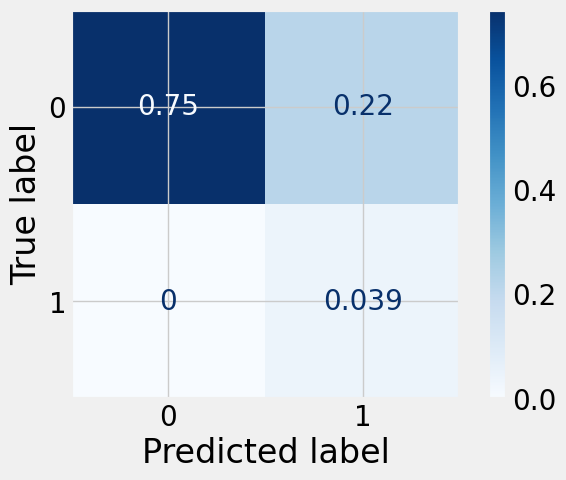

In [31]:
# Fit and plot!
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
print(f"Accuracy Score is: {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                        display_labels=logisticRegr.classes_,
                                        cmap=plt.cm.Blues, normalize='all')